# Plot pupil size vs stimulus luminance correlation

## TODO:

In [1]:
run -im djd.main -- --dbname=dj_hmov

Connecting write@huxley.neuro.bzm:3306
Connected to database 'dj_hmov' as 'write@10.153.173.165'


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
# warnings.filterwarnings("ignore")

# DJD modules
from djd.hmov_unit import corr_pupil_size_stim_intensity
from djd.util import cm2inch
from djd.plot import adjust_spines, get_color_dict

## Get unit keys

In [4]:
df = pd.DataFrame((Series.Experiment() & HmovUnit()).fetch(dj.key, as_dict=True))
df

,m,s,e
0,Ntsr1Cre_2019_0007,6,9
1,Ntsr1Cre_2019_0008,3,7
2,Ntsr1Cre_2019_0008,5,8
3,Ntsr1Cre_2019_0008,6,6
4,Ntsr1Cre_2019_0008,7,6
5,Ntsr1Cre_2020_0001,2,7
6,Ntsr1Cre_2020_0001,3,6
7,Ntsr1Cre_2020_0001,3,10
8,Ntsr1Cre_2020_0002,3,6
9,Ntsr1Cre_2020_0002,4,8


## Get pupil size vs stimulus luminance cross-correlation

In [43]:
# Get cross corr for individual experiments
corrs = []
lags = []
err_list = []

for i, key in df.head(n=len(df)).iterrows(): # n=len(df)
    key = key.to_dict()
    try:
        corr, lag = corr_pupil_size_stim_intensity(key, kind='cross-corr')
        corrs.append(corr), lags.append(lag)
    except:
        print(f'Error for {key}')
        err_list.append(key)
        continue

print('Error list:', err_list)

Stimulus.HmovScenes.export_scene_seq(): hmov03_randseq01_16x25.npy already exists. Loading file from: /Volumes/mudata/exxpResources/hollymov/hmov_03/dataloader  ...
Stimulus.HmovScenes.export_scene_seq(): hmov03_randseq01_16x25.npy already exists. Loading file from: /Volumes/mudata/exxpResources/hollymov/hmov_03/dataloader  ...
Stimulus.HmovScenes.export_scene_seq(): hmov03_randseq01_16x25.npy already exists. Loading file from: /Volumes/mudata/exxpResources/hollymov/hmov_03/dataloader  ...
Error for {'m': 'Ntsr1Cre_2019_0008', 's': 6, 'e': 6}
Error for {'m': 'Ntsr1Cre_2019_0008', 's': 7, 'e': 6}
Error for {'m': 'Ntsr1Cre_2020_0001', 's': 2, 'e': 7}
Error for {'m': 'Ntsr1Cre_2020_0001', 's': 3, 'e': 6}
Error for {'m': 'Ntsr1Cre_2020_0001', 's': 3, 'e': 10}
Stimulus.HmovScenes.export_scene_seq(): hmov03_randseq06_16x25.npy already exists. Loading file from: /Volumes/mudata/exxpResources/hollymov/hmov_03/dataloader  ...
Stimulus.HmovScenes.export_scene_seq(): hmov03_randseq07_16x25.npy al

In [44]:
# Unify experiment-wise cross-corrs of different length into single array
minlag = np.min([i[-1] for i in lags])  # find experiment w smallest lag range
print('minlag = ±', minlag, 's')

# Apply minlag to all experiments to get same trange
for i, l in enumerate(lags):
    corrs[i] = corrs[i][(l >= -minlag) & (l <= minlag)]
    lags[i] = lags[i][(l >= -minlag) & (l <= minlag)]

corrs = np.stack(corrs)
lags = np.stack(lags)

corrs_mean = np.mean(corrs, axis=0)

minlag = ± 937.0576923076923 s


## Plot

In [45]:
## Update plot parameters
# Option 1: Update general pars from modified matplotlibrc file
plt.rcParams.update(mpl.rc_params_from_file('../../matplotlibrc', fail_on_error=False, use_default_template=True))

# Option 2: Dynamically update general pars (use if not updating from modified matplotlibrc)
plt.rcParams.update({
#     'figure.dpi': 100,
    'figure.max_open_warning': 0, 
    'axes.labelsize': 'medium',
    'font.sans-serif': ['Arial'],
    'pdf.fonttype': 42, # make text editable (otherwise saved as non-text path/shape)
    'ps.fonttype': 42, # make text editable (otherwise saved as non-text path/shape)
    })

# Dynamically update plot-specific pars
plt.rcParams.update({
#     'figure.dpi': 100,
    'figure.max_open_warning': 0, 
    'axes.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
#     'ytick.major.pad': 1, # 3.5
    'axes.labelsize': 7.0,
    'axes.titlesize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    })

Text(0, 0.5, 'Normalized cross-correlation')

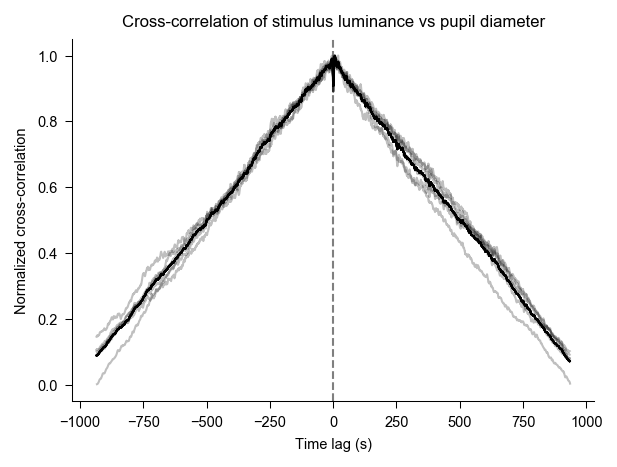

In [46]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.plot(lags.T, corrs.T, 'k', alpha=0.25)
plt.plot(lags.T, corrs_mean, 'k')
ax.axvline(x=0, ymin=0, ymax=1, color='k', linestyle='--', alpha=0.5, zorder=-1)
# maxcorr = lags[np.where(corr == np.max(corr))[0]]  # find max crosscorr
# ax.axvline(x=maxcorr, ymin=0, ymax=1, color='r', linestyle='--', zorder=-1)
# ax.set_xlim([-1,1])
ax.set_title('Cross-correlation of stimulus luminance vs pupil diameter')
ax.set_xlabel('Time lag (s)')
ax.set_ylabel('Normalized cross-correlation')  # 'Discrete lin cross-corr'

In [47]:
# Find minimum cross-corr within defined centre time range
# -> This identifies the time lag between stim luminance increase and pupil constriction
trange = [-5, 5]
lags_range = lags[0][(lags[0] >= trange[0]) & (lags[0] < trange[-1])]
corrs_range = corrs_mean[(lags[0] >= trange[0]) & (lags[0] < trange[-1])]
mincorr = corrs_range[np.where(corrs_range == np.min(corrs_range))[0]]  # find min crosscorr
mincorr_t = lags_range[np.where(corrs_range == np.min(corrs_range))[0]]  # find min crosscorr tpoint
mincorr_t

array([0.38461538])

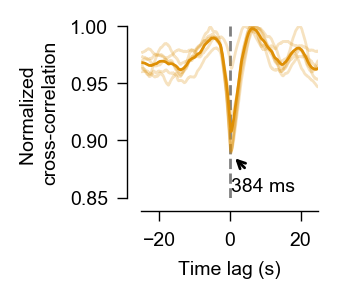

In [63]:
## Plot stimulus-pupil diameter cross-correlation

# Get default colors for opto, locomotion and eye data
col_dict = get_color_dict(color_names=['blue','orange', 'green', 'red', 'purple',
                                       'brown', 'pink', 'gray', 'yellow', 'lightblue'])
col = col_dict['orange']  # eye color is orange

fig, ax = plt.subplots(figsize=cm2inch((4,3.5)), dpi=200)

ax.plot(lags.T, corrs.T, color=col, alpha=0.25)
ax.plot(lags[0], corrs_mean, color=col)

ax.axvline(x=0, ymin=0, ymax=1, color='k', linestyle='--', alpha=0.5, zorder=-1)
ax.annotate(f'{np.int(mincorr_t[0]*1000)} ms', xy=(mincorr_t, mincorr-0.02), xytext=(mincorr_t, mincorr-0.04), ha='left', va='top', size=7,
            arrowprops=dict(facecolor='black', arrowstyle='->', relpos=(0.5,0.5)))# width=0.05, shrink=0.5))
ax.set_xlim([-25,25])
ax.set_ylim([0.85,1])
# ax.set_title('Cross-correlation of \nstimulus luminance vs pupil diameter')
ax.set_xlabel('Time lag (s)')
ax.set_ylabel('Normalized \ncross-correlation')  # 'Discrete lin cross-corr'

adjust_spines(ax, ['bottom', 'left'])

plt.savefig('eye_stim_luminance_cross_corr.pdf')

## Get pupil size vs stimulus luminance correlation

In [64]:
corrs = np.full(len(df), np.nan) # same: (0) np.full_like(keys, np.nan), (1) np.full(len(df), np.nan) (2) np.empty(len(keys)) * np.nan
err_list = []

for i, key in df.head(n=len(df)).iterrows(): # n=len(df)
    key = key.to_dict()
    try:
        corrs[i], _ = corr_pupil_size_stim_intensity(key, kind='pearsonr', shift_eye_t=-0.384) # -0.384
    except:
        print(f'Error for {key}')
        err_list.append(key)
        continue

# Remove NaNs
corrs = corrs[~np.isnan(corrs)]
print('Error list:', err_list)

Stimulus.HmovScenes.export_scene_seq(): hmov03_randseq01_16x25.npy already exists. Loading file from: /Volumes/mudata/exxpResources/hollymov/hmov_03/dataloader  ...
Stimulus.HmovScenes.export_scene_seq(): hmov03_randseq01_16x25.npy already exists. Loading file from: /Volumes/mudata/exxpResources/hollymov/hmov_03/dataloader  ...
Stimulus.HmovScenes.export_scene_seq(): hmov03_randseq01_16x25.npy already exists. Loading file from: /Volumes/mudata/exxpResources/hollymov/hmov_03/dataloader  ...
Error for {'m': 'Ntsr1Cre_2019_0008', 's': 6, 'e': 6}
Error for {'m': 'Ntsr1Cre_2019_0008', 's': 7, 'e': 6}
Error for {'m': 'Ntsr1Cre_2020_0001', 's': 2, 'e': 7}
Error for {'m': 'Ntsr1Cre_2020_0001', 's': 3, 'e': 6}
Error for {'m': 'Ntsr1Cre_2020_0001', 's': 3, 'e': 10}
Stimulus.HmovScenes.export_scene_seq(): hmov03_randseq06_16x25.npy already exists. Loading file from: /Volumes/mudata/exxpResources/hollymov/hmov_03/dataloader  ...
Stimulus.HmovScenes.export_scene_seq(): hmov03_randseq07_16x25.npy al

## Plot

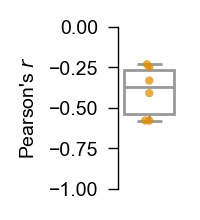

In [110]:
## Plot stim-pupil correlations

# Get default colors for opto, locomotion and eye data
col_dict = get_color_dict(color_names=['blue','orange', 'green', 'red', 'purple',
                                       'brown', 'pink', 'gray', 'yellow', 'lightblue'])
col = col_dict['orange']  # eye color is orange

fig, ax = plt.subplots(figsize=cm2inch((2.25,2.5)), dpi=200)
sns.boxplot(y=corrs, ax=ax, color='w')#, zorder=-1)
sns.swarmplot(y=corrs, color=col, edgecolor=col, size=3, alpha=0.75, ax=ax)
# ax.set_title(f'Correlation of stimulus luminance vs pupil diameter\n n$_{{exp}}$={len(corrs)}')
ax.set_ylabel("Pearson's $r$")

ax.set_ylim([-1,0])
ax.spines['bottom'].set_visible(False)
plt.setp(ax.xaxis.get_ticklines(), color='none')

plt.savefig('eye_stim_luminance_corr.pdf')

Text(0.5, 0, 'Correlation coefficient (PearsonR)')

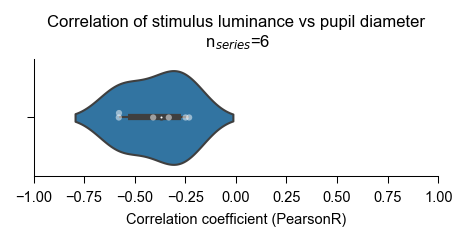

In [27]:
fig, ax = plt.subplots(figsize=(3,1.5), dpi=150)
# sns.set_theme(style="whitegrid")
# tips = sns.load_dataset("tips")
sns.violinplot(x=corrs, ax=ax)
# sns.swarmplot(x=corrs, color='w', edgecolor='w', facecolor='none', size=5, alpha=1, ax=ax)
sns.swarmplot(x=corrs, color='white', edgecolor='gray', size=3, alpha=0.5, ax=ax)
ax.set_xlim([-1,1])
ax.set_title(f'Correlation of stimulus luminance vs pupil diameter\n n$_{{series}}$={len(corrs)}')
ax.set_xlabel('Correlation coefficient (PearsonR)')


## Stats tests